# DETR-Pose

In [1]:
# ✅ Step 1: Install dependencies
!pip install -q transformers pycocotools opencv-python

In [7]:
import os
import json
import cv2
import requests
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from pycocotools.coco import COCO
from transformers import DetrImageProcessor, DetrForObjectDetection



# ✅ Step 2: Prepare COCO val2017 subset
os.makedirs('dataset/annotations', exist_ok=True)
os.makedirs('dataset/images', exist_ok=True)

# Download annotations
# !wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !unzip -q annotations_trainval2017.zip -d dataset/

In [16]:
coco = COCO('dataset/annotations/person_keypoints_val2017.json')
img_ids = coco.getImgIds(catIds=coco.getCatIds(catNms=['person']))[:500]


for img_id in tqdm(img_ids):
    info = coco.loadImgs(img_id)[0]
    url = info['coco_url']
    out_path = f'dataset/images/{info["file_name"]}'
    if not os.path.exists(out_path):
        with open(out_path, 'wb') as f:
            f.write(requests.get(url).content)

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


100%|██████████| 500/500 [00:00<00:00, 163609.92it/s]


In [17]:
# ✅ Step 3: Load DETR for Person Detection (Hugging Face)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
detector = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

# ✅ Step 4:  Define PyTorch Keypoint Regression Model (Simple CNN)
class KeypointHead(nn.Module):
    def __init__(self, num_keypoints=17):
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.head = nn.Conv2d(128, num_keypoints, 1)

    def forward(self, x):
        return self.head(self.backbone(x))  # output: (B, 17, H, W)

model = KeypointHead().cuda()

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
# ✅ Step 4:  Custom Dataset Class (DETR Person Crops + COCO Keypoints)
class CocoKeypointCropDataset(Dataset):
    def __init__(self, image_dir, coco, img_ids, transform=None):
        self.image_dir = image_dir
        self.coco = coco
        self.img_ids = img_ids
        self.transform = transform

    def _generate_heatmap(self, kpts, output_size=64):
        heatmap = np.zeros((17, output_size, output_size), dtype=np.float32)
        for i, (x, y, v) in enumerate(kpts):
            if v < 1: continue
            x = int(x * output_size / 256)
            y = int(y * output_size / 256)
            xx, yy = np.meshgrid(np.arange(output_size), np.arange(output_size))
            heatmap[i] = np.exp(-((xx - x)**2 + (yy - y)**2) / 2)
        return heatmap

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")

        # Detect persons
        inputs = processor(images=img, return_tensors="pt")
        outputs = detector(**inputs)
        target_size = torch.tensor([img.size[::-1]])
        results = processor.post_process_object_detection(outputs, target_sizes=target_size, threshold=0.8)[0]

        boxes = results['boxes']
        if len(boxes) == 0:
            return self.__getitem__((idx + 1) % len(self))  # retry

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        kpts = np.zeros((17, 3))

        for ann in anns:
            if ann['num_keypoints'] > 0:
                kpts = np.array(ann['keypoints']).reshape(-1, 3)
                break

        visible = kpts[kpts[:, 2] > 0][:, :2]
        if visible.shape[0] == 0:
            return self.__getitem__((idx + 1) % len(self))

        # Compute tight box around visible keypoints
        x1, y1 = visible.min(0)
        x2, y2 = visible.max(0)

        # Add some padding (e.g., 20%)
        pad = 0.2
        w, h = x2 - x1, y2 - y1
        x1 = max(int(x1 - pad * w), 0)
        y1 = max(int(y1 - pad * h), 0)
        x2 = min(int(x2 + pad * w), img.width)
        y2 = min(int(y2 + pad * h), img.height)

        # Crop and resize
        img_np = np.array(img)
        crop = img_np[y1:y2, x1:x2]
        crop = cv2.resize(crop, (256, 256))


        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        kpts = np.zeros((17, 3))
        for ann in anns:
            if ann['num_keypoints'] > 0:
                kpts = np.array(ann['keypoints']).reshape(-1, 3)
                break

        if self.transform:
            crop = self.transform(crop)

        heatmap = self._generate_heatmap(kpts)
        return crop, torch.tensor(heatmap, dtype=torch.float32)


transform = transforms.Compose([transforms.ToTensor()])
dataset = CocoKeypointCropDataset('dataset/images', coco, img_ids, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [20]:
# ✅ Step 5: Train Loop
for epoch in range(1):
    epoch_loss = 0.0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}", leave=False)

    for imgs, heatmaps in pbar:
        imgs, heatmaps = imgs.cuda(), heatmaps.cuda()
        out = model(imgs)
        loss = loss_fn(out, heatmaps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({'Batch Loss': loss.item()})

    print(f"Epoch {epoch+1}, Avg Loss: {epoch_loss / len(dataloader):.4f}")

Epoch 1, Avg Loss: 0.0002


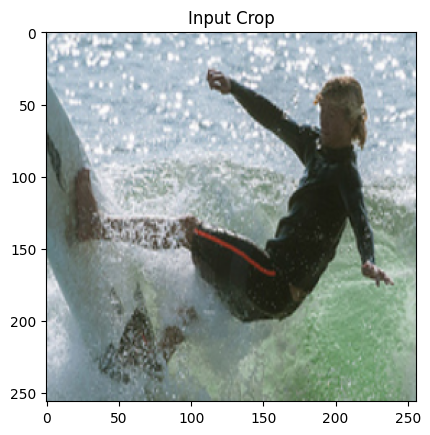

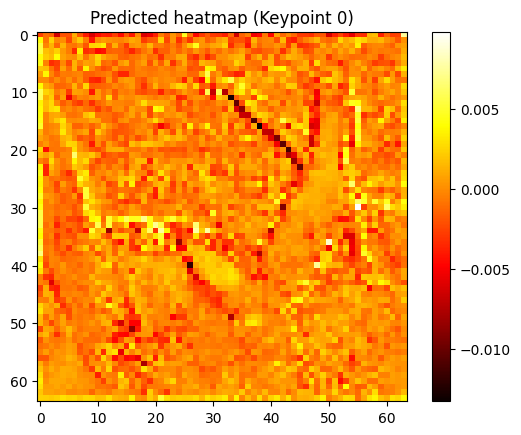

In [32]:
# ✅ Step 6: Inference + Visualization
model.eval()
img, gt = dataset[5]
with torch.no_grad():
    pred = model(img.unsqueeze(0).cuda())[0].cpu()

plt.imshow(img.permute(1, 2, 0))
plt.title("Input Crop")
plt.show()

plt.imshow(pred[0], cmap='hot')
plt.title("Predicted heatmap (Keypoint 0)")
plt.colorbar()
plt.show()